In [1]:
# Imports we will use
import torch
import gc
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Function
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import random
from pathlib import Path
from sklearn.metrics import r2_score
from astropy.visualization import make_lupton_rgb
from sklearn.manifold import Isomap
from train_utils import *
import time
import os
import json

%matplotlib inline
plt.rcParams.update({'font.size': 12})

# Find if cuda is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [4]:
#fix seed
seed = 12
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.enabled=False
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(seed)

## Load Data

In [5]:
# Specify paths, load in data, and subsample labels
head = Path.cwd().parents[1]
source_img_path = head / 'data/mb_paper_source_final/mb_paper_source_final.npy'
target_img_path = head / 'data/mb_paper_target_final/mb_paper_target_final.npy'
source_meta = head / 'data/mb_paper_source_final/mb_paper_source_final_metadata.csv'
target_meta = head / 'data/mb_paper_target_final/mb_paper_target_final_metadata.csv'
batch_size = 128
source_train_dataloader, source_test_dataloader, source_val_dataloader, source_data = create_dataloader(source_img_path, source_meta, batch_size)
target_train_dataloader, target_test_dataloader, target_val_dataloader, target_data = create_dataloader(target_img_path, target_meta, batch_size)
isomap_source_label_sample = pd.read_csv(source_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]
isomap_target_label_sample = pd.read_csv(target_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]

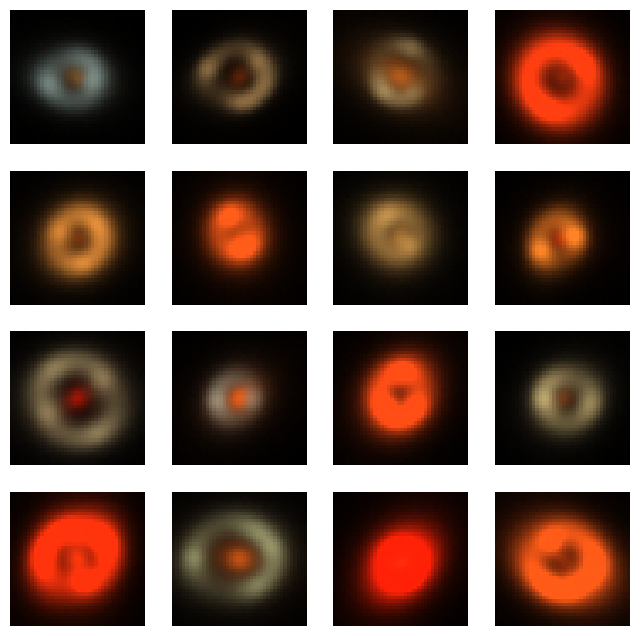

In [6]:
# Visualize source data
visualize_data(source_data)

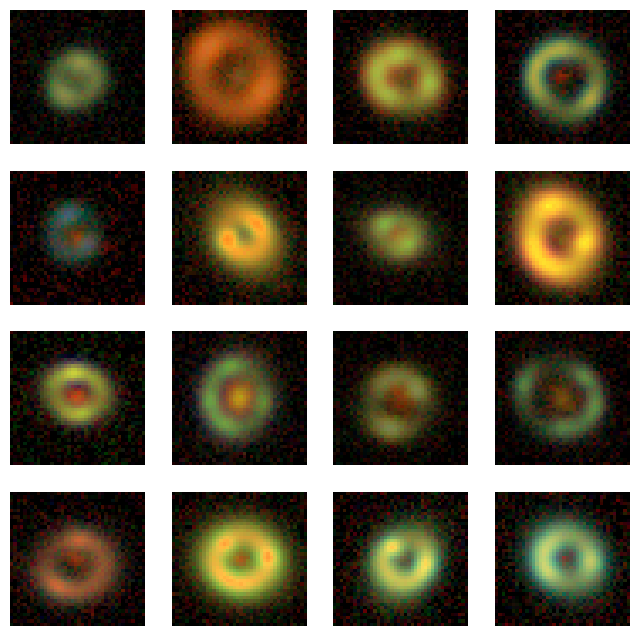

In [7]:
# Visualize target data
visualize_data(target_data)

## Model Setup

In [8]:
# Choose how you prefer to evolve beta and the DA Weight
def da_weight_function(epoch):
    """ Linear evolving DA weighting in loss function. """
    if epoch < evolv_epoch:
        da_weight = init_wt_da - ((init_wt_da - final_wt_da) * (epoch / n_epoch))
    else:
        da_weight = final_wt_da
    return da_weight

def beta_function(epoch):
    """ Linear evolving beta weighting in loss function until halfway through total epochs. """
    if epoch < evolv_epoch:
        beta_val = beta_init - (beta_init - beta_final) * (epoch / evolv_epoch)
    else:
        beta_val = beta_final
    return beta_val

# Initialize hyperparameters
learning_rate = 1e-5
n_epoch = 300

evolv_epoch = 250
init_wt_da = 1.4
final_wt_da = 1.0
beta_init = 1.0
beta_final = 0.0

In [9]:
from torch.optim.lr_scheduler import MultiStepLR
# Initialize model
model = NeuralNetworkMVE(npix=40).cuda()

# Loss Functions / Optimizers
regressor_loss_fn = nn.MSELoss().cuda()
da_loss_fn = MMD_loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = MultiStepLR(optimizer, milestones=[100, 200, 250, 275], gamma=0.5)

In [10]:
# To continue training from a past model, enter path into load_mod_name
# Else, enter None, and you still have to run the function.
# Then, enter save_mod_name to save for the current run  

load_mod_name = None #"models/papermve_v1_aug20_1940_A" # "models/start_code_test_2"
stats, model, optimizer, best_target_R2, best_mve_loss = initialize_state(load_mod_name, model, optimizer)


#save_mod_name = load_mod_name # may overwrite loaded model
save_mod_name = "models/papermve_v3_aug22_1315_B"

## Train

Beginning Training...
Generating Isomap...


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


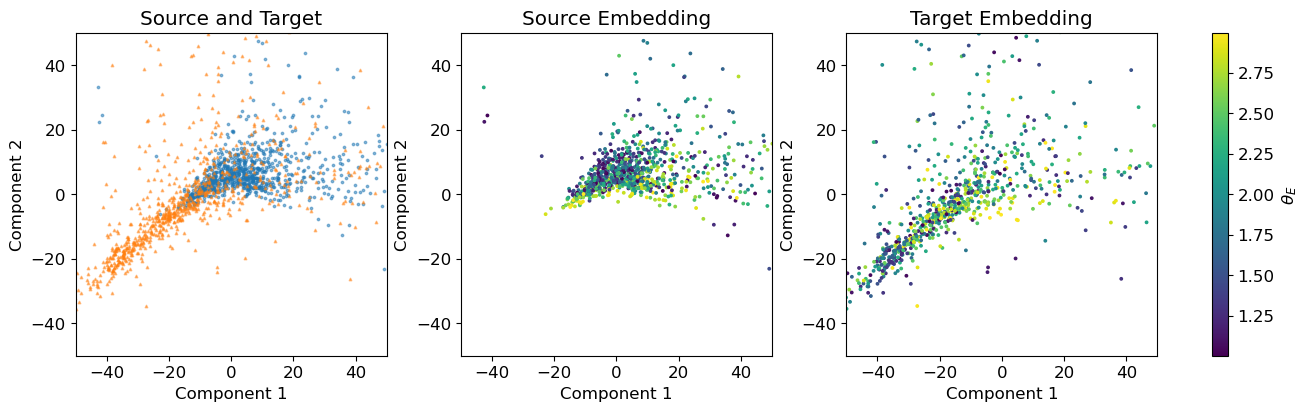


Epoch 0: 41.46s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3166
	Train Regression Loss: : 2.3733
	Train Mve Loss: : 1.0315
	Train R2 Score: : -6.2078
 Validation Statistics:
	Val Source Regression Loss: : 1.6230
	Val Target Regression Loss: : 1.5381
	Val Source R2 Score: : -4.0220
	Val Target R2 Score: : -3.6042
	Val Source Mve Loss: : 0.6413
	Val Target Mve Loss: : 0.5984
Saving Model MVE... Done.

Epoch 1: 47.28s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2723
	Train Regression Loss: : 1.1266
	Train Mve Loss: : 0.4014
	Train R2 Score: : -2.4063
 Validation Statistics:
	Val Source Regression Loss: : 0.7453
	Val Target Regression Loss: : 0.7084
	Val Source R2 Score: : -1.2795
	Val Target R2 Score: : -1.1077
	Val Source Mve Loss: : 0.2148
	Val Target Mve Loss: : 0.2005
Saving Model MVE... Done.

Epoch 2: 50.33s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.2164
	Train Regression Loss: : 0.5484
	Tr

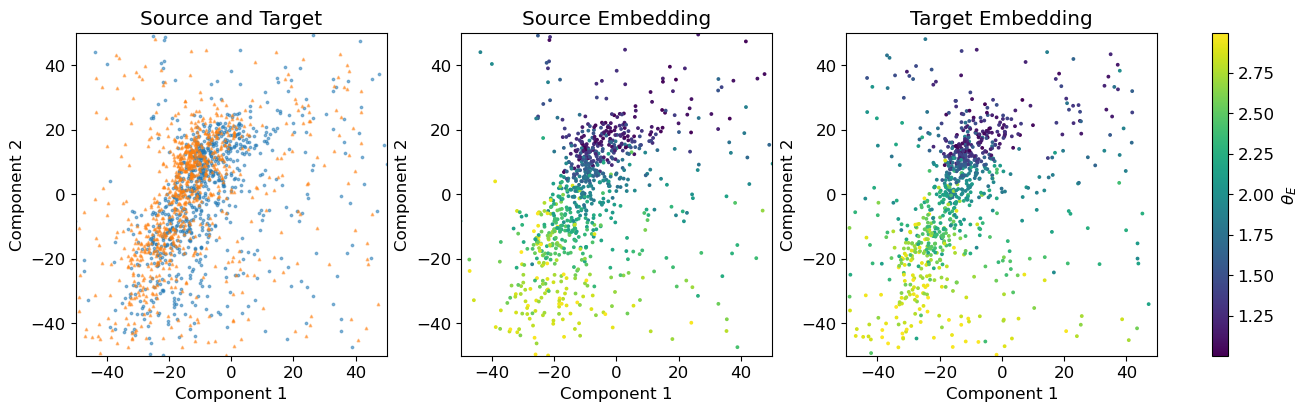

Saving Model... Done.

Epoch 20: 44.29s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0445
	Train Regression Loss: : 0.0276
	Train Mve Loss: : -0.0772
	Train R2 Score: : 0.9164
 Validation Statistics:
	Val Source Regression Loss: : 0.0274
	Val Target Regression Loss: : 0.0439
	Val Source R2 Score: : 0.9146
	Val Target R2 Score: : 0.8697
	Val Source Mve Loss: : -0.0711
	Val Target Mve Loss: : -0.0685
Saving Model... Done.

Epoch 21: 48.78s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0439
	Train Regression Loss: : 0.0265
	Train Mve Loss: : -0.0673
	Train R2 Score: : 0.9196
 Validation Statistics:
	Val Source Regression Loss: : 0.0259
	Val Target Regression Loss: : 0.0431
	Val Source R2 Score: : 0.9208
	Val Target R2 Score: : 0.8718
	Val Source Mve Loss: : -0.0685
	Val Target Mve Loss: : -0.0651
Saving Model... Done.

Epoch 22: 45.11s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0417
	Train Regression L

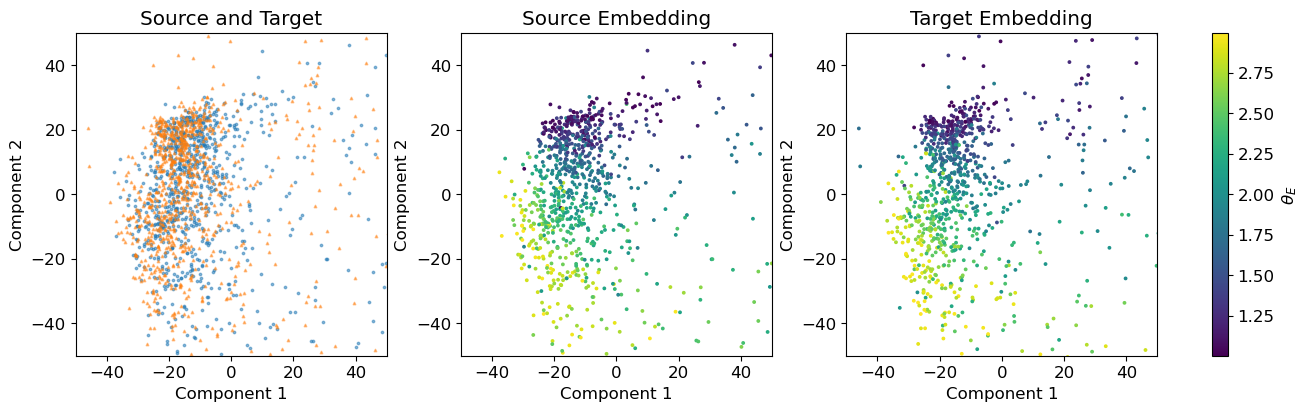

Saving Model... Done.

Epoch 40: 42.33s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0336
	Train Regression Loss: : 0.0169
	Train Mve Loss: : -0.0972
	Train R2 Score: : 0.9487
 Validation Statistics:
	Val Source Regression Loss: : 0.0171
	Val Target Regression Loss: : 0.0228
	Val Source R2 Score: : 0.9478
	Val Target R2 Score: : 0.9328
	Val Source Mve Loss: : -0.0869
	Val Target Mve Loss: : -0.0865
Saving Model... Done.

Epoch 41: 50.62s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0339
	Train Regression Loss: : 0.0166
	Train Mve Loss: : -0.0724
	Train R2 Score: : 0.9495
 Validation Statistics:
	Val Source Regression Loss: : 0.0167
	Val Target Regression Loss: : 0.0224
	Val Source R2 Score: : 0.9488
	Val Target R2 Score: : 0.9333
	Val Source Mve Loss: : -0.0648
	Val Target Mve Loss: : -0.0648
Saving Model... Done.

Epoch 42: 45.51s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0321
	Train Regression L

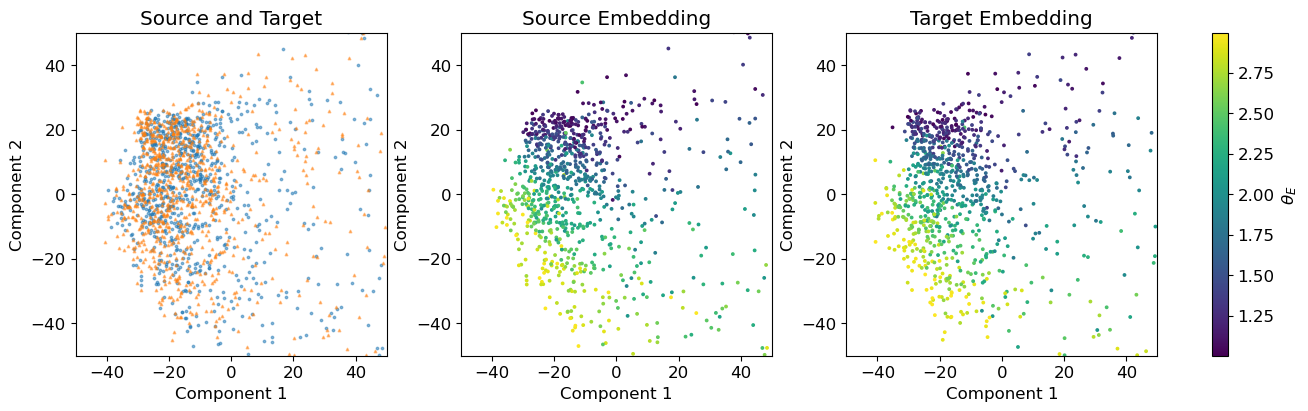

Saving Model... Done.

Epoch 60: 46.09s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0299
	Train Regression Loss: : 0.0134
	Train Mve Loss: : -0.1722
	Train R2 Score: : 0.9592
 Validation Statistics:
	Val Source Regression Loss: : 0.0141
	Val Target Regression Loss: : 0.0185
	Val Source R2 Score: : 0.9571
	Val Target R2 Score: : 0.9450
	Val Source Mve Loss: : -0.1537
	Val Target Mve Loss: : -0.1504

Epoch 61: 44.35s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0298
	Train Regression Loss: : 0.0133
	Train Mve Loss: : -0.1309
	Train R2 Score: : 0.9596
 Validation Statistics:
	Val Source Regression Loss: : 0.0136
	Val Target Regression Loss: : 0.0187
	Val Source R2 Score: : 0.9582
	Val Target R2 Score: : 0.9448
	Val Source Mve Loss: : -0.1173
	Val Target Mve Loss: : -0.1147

Epoch 62: 43.93s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0290
	Train Regression Loss: : 0.0134
	Train Mve Loss: : -0.1162
	Tr

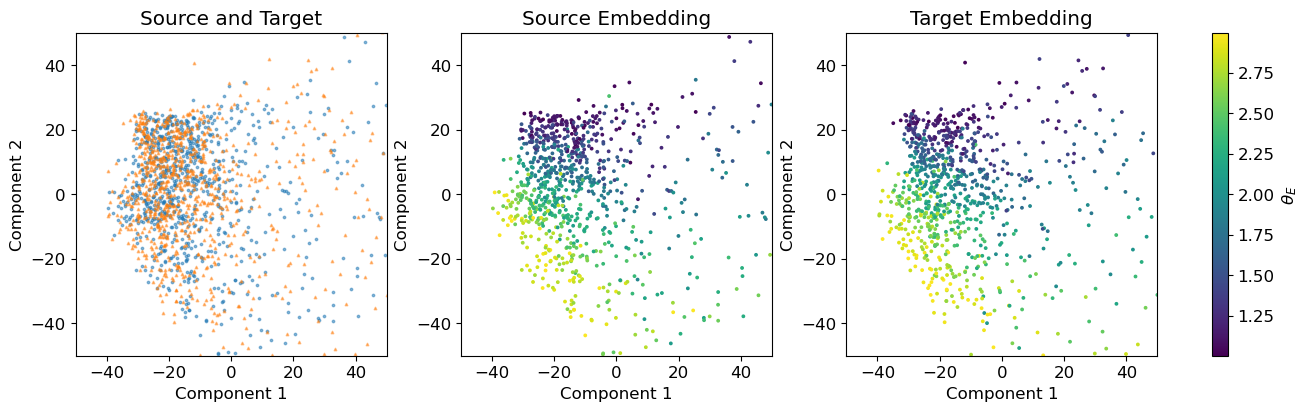


Epoch 80: 51.22s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0289
	Train Regression Loss: : 0.0123
	Train Mve Loss: : -0.1992
	Train R2 Score: : 0.9626
 Validation Statistics:
	Val Source Regression Loss: : 0.0127
	Val Target Regression Loss: : 0.0169
	Val Source R2 Score: : 0.9611
	Val Target R2 Score: : 0.9495
	Val Source Mve Loss: : -0.1993
	Val Target Mve Loss: : -0.1984

Epoch 81: 47.28s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0286
	Train Regression Loss: : 0.0122
	Train Mve Loss: : -0.1843
	Train R2 Score: : 0.9631
 Validation Statistics:
	Val Source Regression Loss: : 0.0125
	Val Target Regression Loss: : 0.0169
	Val Source R2 Score: : 0.9617
	Val Target R2 Score: : 0.9501
	Val Source Mve Loss: : -0.1786
	Val Target Mve Loss: : -0.1791

Epoch 82: 45.92s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0284
	Train Regression Loss: : 0.0122
	Train Mve Loss: : -0.1613
	Train R2 Score: : 0.9631

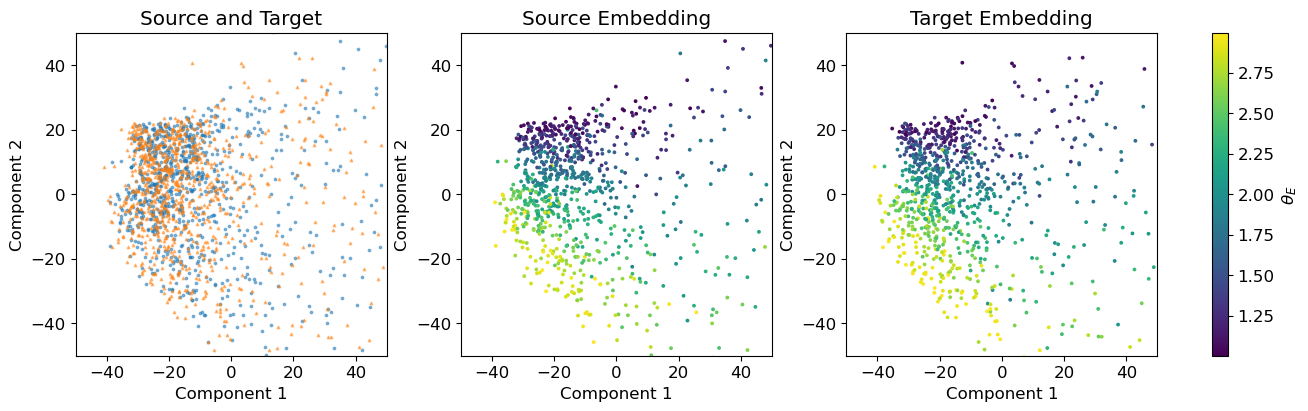


Epoch 100: 38.62s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0277
	Train Regression Loss: : 0.0112
	Train Mve Loss: : -0.1827
	Train R2 Score: : 0.9662
 Validation Statistics:
	Val Source Regression Loss: : 0.0113
	Val Target Regression Loss: : 0.0162
	Val Source R2 Score: : 0.9652
	Val Target R2 Score: : 0.9522
	Val Source Mve Loss: : -0.1621
	Val Target Mve Loss: : -0.1581

Epoch 101: 41.98s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0276
	Train Regression Loss: : 0.0111
	Train Mve Loss: : -0.2322
	Train R2 Score: : 0.9663
 Validation Statistics:
	Val Source Regression Loss: : 0.0113
	Val Target Regression Loss: : 0.0156
	Val Source R2 Score: : 0.9654
	Val Target R2 Score: : 0.9536
	Val Source Mve Loss: : -0.2152
	Val Target Mve Loss: : -0.2154

Epoch 102: 47.20s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0279
	Train Regression Loss: : 0.0111
	Train Mve Loss: : -0.1792
	Train R2 Score: : 0.9

In [ ]:
print("Beginning Training...")

stats['lr'] = []
for curr_epoch in range(stats['epoch_no'], stats['epoch_no'] + n_epoch):

        # Generate isomaps every 20 epochs
        if (curr_epoch % 20 == 0):
            print("Generating Isomap...")
            source_iso, target_iso = generate_isomaps(source_data, target_data, model)
            show_isomaps(source_iso, 
                         target_iso, 
                         isomap_source_label_sample, 
                         isomap_target_label_sample, 
                         save_mod_name, 
                         name = stats["epoch_no"], 
                         axlim = 50, save = True)

        # Save best models
        if (len(stats['val_target_r2_score']) > 0):
            
            # Save and overwrite model every best target R2
            if (stats['val_target_r2_score'][-1] > best_target_R2):
                print("Saving Model...", end = ' ')
                save_model(save_mod_name, model, optimizer, stats)
                best_target_R2 = stats['val_target_r2_score'][-1]
                print("Done.")
                
            # Save and overwrite model every best target MVE Loss
            if (stats['val_target_mve_loss'][-1] < best_mve_loss):
                print("Saving Model MVE...", end = ' ')
                mve_name = save_mod_name + "_mve"
                save_model(mve_name, model, optimizer, stats)
                best_mve_loss = stats['val_target_mve_loss'][-1]
                print("Done.")

            if ((curr_epoch > 250) and (stats['val_target_r2_score'][-1] > 0.95) and (stats['val_target_mve_loss'][-1] < -1)):
                print("Saving Model Minima...", end = ' ')
                m_name = save_mod_name + f"_{curr_epoch}"
                save_model(m_name, model, optimizer, stats)
                print("Done.")

        
        start_time = time.time()

        beta = beta_function(curr_epoch)
        da_weight = da_weight_function(curr_epoch)

        # Train, backpropagate
        vals = train_loop_mve(source_train_dataloader, 
                              target_train_dataloader, 
                              model,
                              regressor_loss_fn, 
                              da_loss_fn, 
                              optimizer,
                              da_weight, 
                              beta)

        # Test, validate metrics
        vals_validate = test_loop_mve(source_val_dataloader, 
                                      target_val_dataloader,
                                      model, 
                                      regressor_loss_fn, 
                                      beta)

        scheduler.step()

        # Training Metrics
        stats['train_DA_loss'].append(vals[0])
        stats['train_regression_loss'].append(vals[1])
        stats['train_mve_loss'].append(vals[2])
        stats['train_r2_score'].append(vals[3])

        # Validation Metrics
        stats['val_source_regression_loss'].append(vals_validate[0])
        stats['val_target_regression_loss'].append(vals_validate[1])
        stats['val_source_r2_score'].append(vals_validate[2])
        stats['val_target_r2_score'].append(vals_validate[3])
        stats['val_source_mve_loss'].append(vals_validate[4])
        stats['val_target_mve_loss'].append(vals_validate[5])
        
        # Other Parameters
        stats['da_weight'].append(da_weight)
        stats['beta'].append(beta)
        stats['epoch_no'] += 1
        stats['lr'].append(scheduler.get_last_lr())
        print_epoch_scores(stats, curr_epoch, time.time() - start_time)

In [ ]:
# Saves the end result model after running for all stages, as well as the .json of stats

state = {
    'epoch': stats['epoch_no'],
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}
final_mod_name = save_mod_name + "_final"
torch.save(state, final_mod_name)
json.dump(stats, open(final_mod_name+'.json', 'w'))

## Visualize Results

In [10]:
# Loads a model for plotting/viz

viz_mod_name = final_mod_name # "models/start_code_test_4_final"
model.load_state_dict(torch.load(viz_mod_name)['state_dict'])
stats = json.load(open(viz_mod_name+'.json', 'r'))

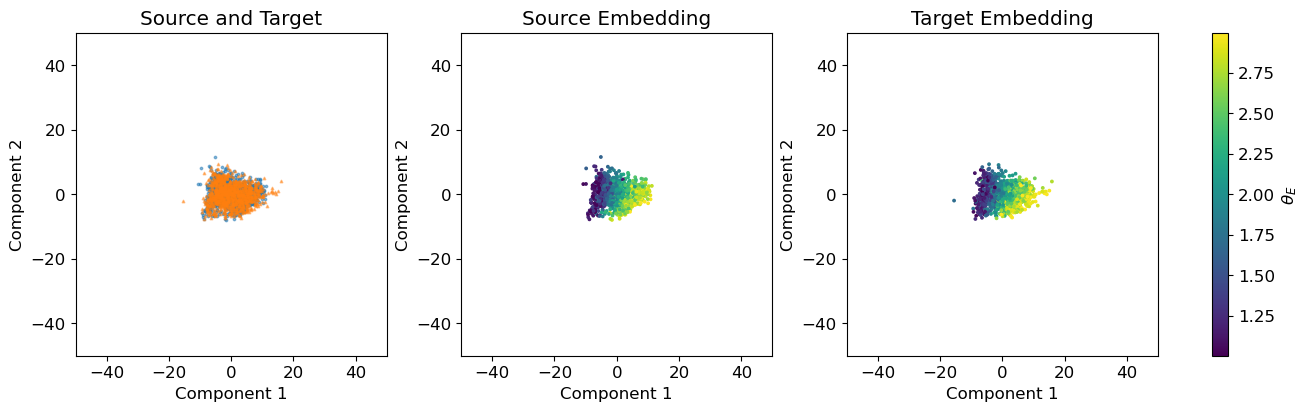

(<Figure size 1300x400 with 4 Axes>,
 array([<Axes: title={'center': 'Source and Target'}, xlabel='Component 1', ylabel='Component 2'>,
        <Axes: title={'center': 'Source Embedding'}, xlabel='Component 1', ylabel='Component 2'>,
        <Axes: title={'center': 'Target Embedding'}, xlabel='Component 1', ylabel='Component 2'>],
       dtype=object))

In [11]:
# Visualize isomaps 
trained_source_iso, trained_target_iso = generate_isomaps(source_data, target_data, model)
show_isomaps(trained_source_iso, trained_target_iso, isomap_source_label_sample, isomap_target_label_sample, viz_mod_name, axlim = 50)

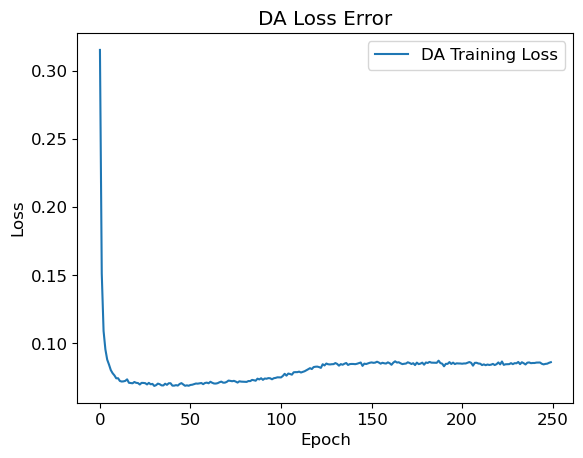

In [12]:
# DA Loss
fmt = lambda k: " ".join([i.capitalize() for i in k.split('_')])
eps = np.arange(stats["epoch_no"])
plt.title("DA Loss Error")
plt.plot(eps, stats['train_DA_loss'], label = "DA Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

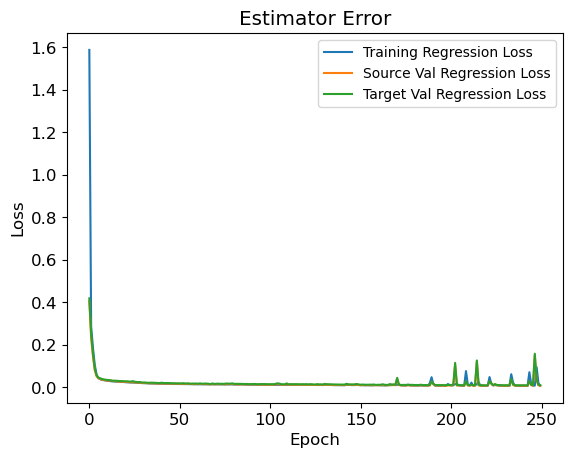

In [13]:
# Estimator / Regression
plt.title("Estimator Error")
plt.plot(eps, stats['train_regression_loss'], label = "Training Regression Loss")
plt.plot(eps, stats['val_source_regression_loss'], label = "Source Val Regression Loss")
plt.plot(eps, stats['val_target_regression_loss'], label = "Target Val Regression Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')

(-1.0, 1.0)

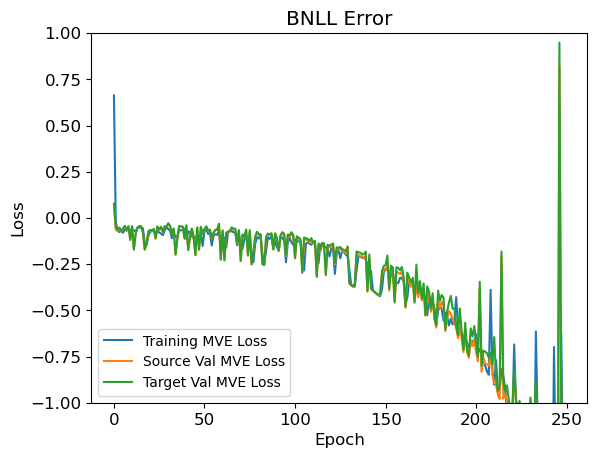

In [14]:
# BNLL for MVE
plt.title("BNLL Error")
plt.plot(eps, stats['train_mve_loss'], label = "Training MVE Loss")
plt.plot(eps, stats['val_source_mve_loss'], label = "Source Val MVE Loss")
plt.plot(eps, stats['val_target_mve_loss'], label = "Target Val MVE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')
plt.ylim(-1, 1)

(0.5, 1.0)

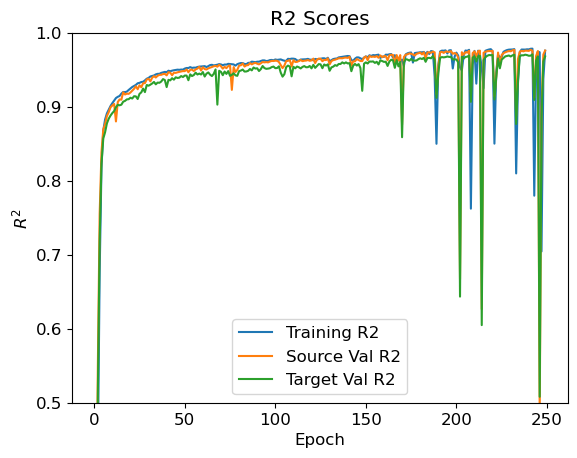

In [15]:
# R2 Scores
plt.title("R2 Scores")
plt.plot(eps, stats['train_r2_score'], label = "Training R2")
plt.plot(eps, stats['val_source_r2_score'], label = "Source Val R2")
plt.plot(eps, stats['val_target_r2_score'], label = "Target Val R2")
plt.xlabel("Epoch")
plt.ylabel("$R^2$")
plt.legend()
plt.ylim(0.5, 1)

In [26]:
# Test Source
var_preds_source = np.array([])
preds_source = np.array([])
true_source = np.array([])
lbnll_source = np.array([])
score_list = np.array([])

with torch.no_grad():
    for X, y in source_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_source = np.append(preds_source, pred[:, 0].cpu())
        var_preds_source = np.append(var_preds_source, pred[:, 1].cpu())
        true_source = np.append(true_source, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_source = np.append(lbnll_source, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.5))

score = np.mean(score_list)
print(f'Source R2 Score is {score:.4f}')

Source R2 Score is 0.9767


Text(0.5, 1.0, 'MMD | Source | R2: 0.977')

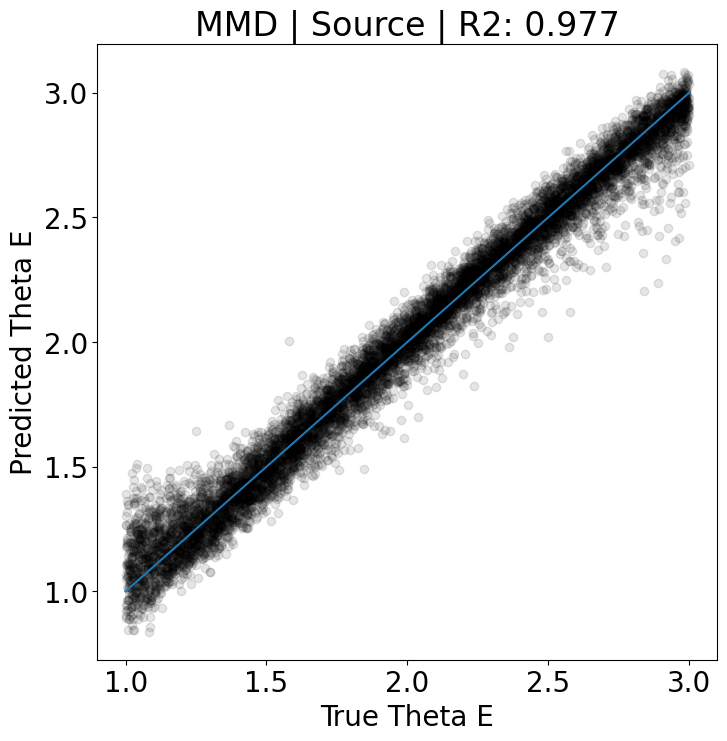

In [27]:
plt.figure(figsize=(8,8))
plt.scatter(true_source, preds_source,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Source | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'Uncertainty | Source | BNLL: -0.175')

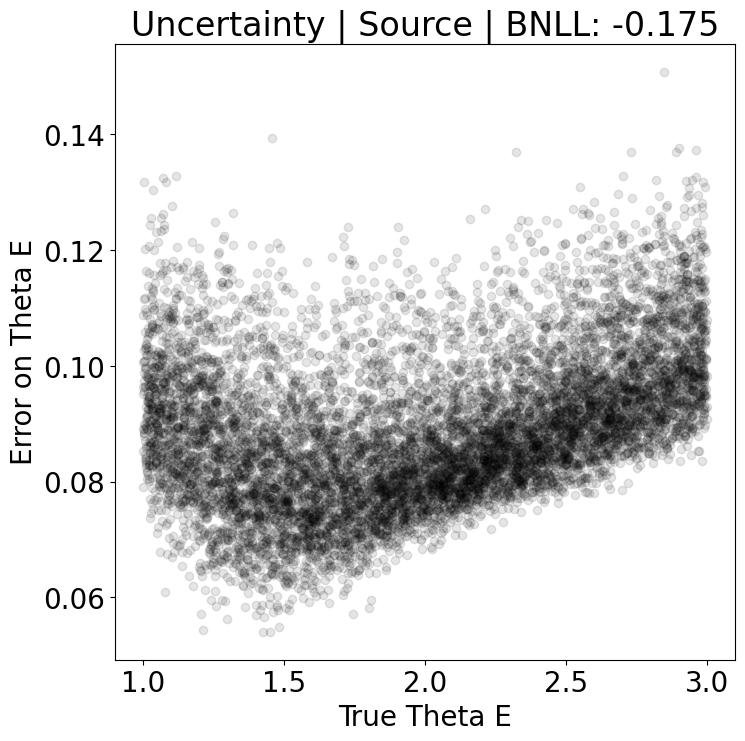

In [28]:
plt.figure(figsize=(8,8))
plt.scatter(true_source, np.sqrt(var_preds_source),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Source | BNLL: {0:.3f}'.format(np.mean(lbnll_source)))

In [29]:
# Test target
preds_target = np.array([])
var_preds_target = np.array([])
true_target = np.array([])
score_list = np.array([])
lbnll_target = np.array([])


with torch.no_grad():
    for X, y in target_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_target = np.append(preds_target, pred[:, 0].cpu())
        var_preds_target = np.append(var_preds_target, pred[:, 1].cpu())
        true_target = np.append(true_target, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_target = np.append(lbnll_target, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.5))


score = np.mean(score_list)
print(f'Target R2 Score is {score:.4f}')

Target R2 Score is 0.9661


Text(0.5, 1.0, 'MMD | Target | R2: 0.966')

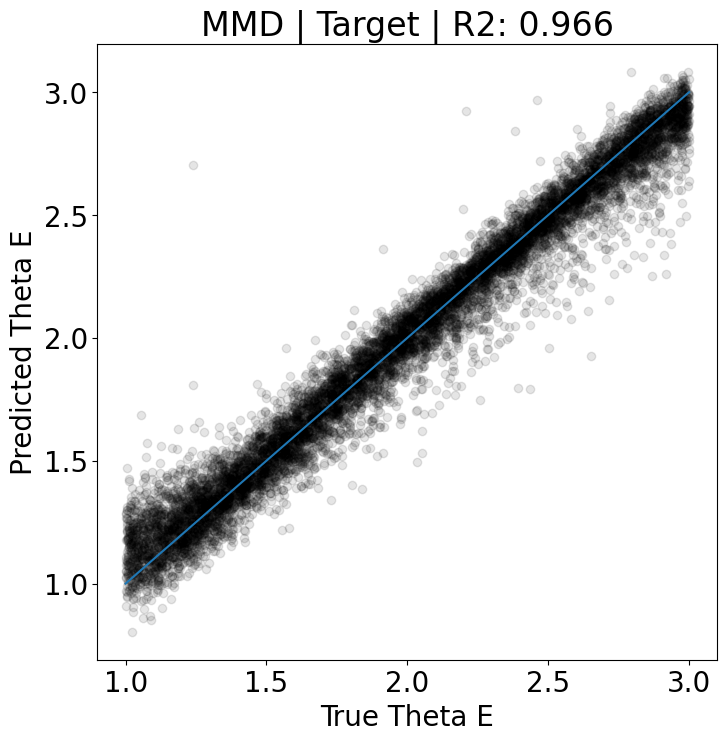

In [30]:
plt.figure(figsize=(8,8))
plt.scatter(true_target, preds_target,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'MMD | Target | R2: 0.966')

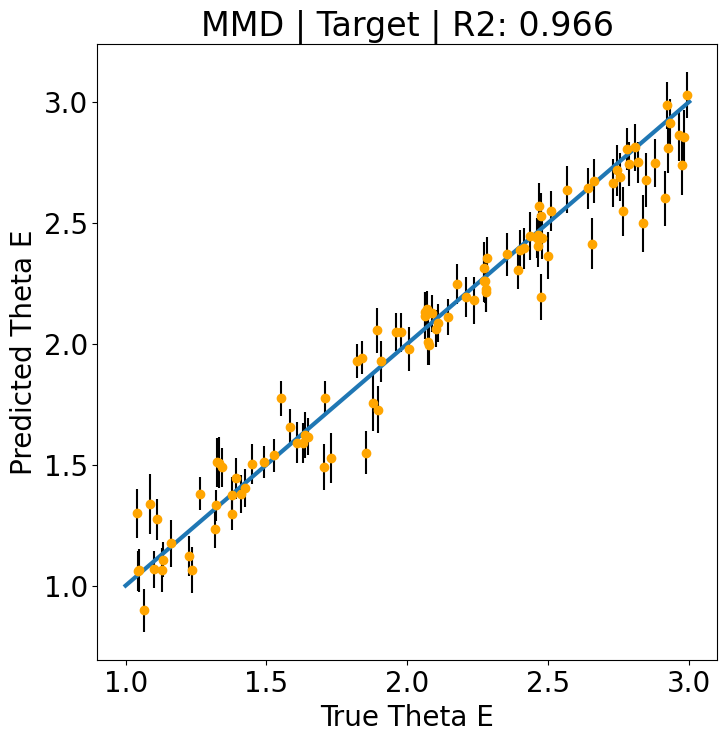

In [31]:
plt.figure(figsize=(8,8))
idx = np.random.choice(np.arange(len(true_target)), 100)
plt.errorbar(true_target[idx], preds_target[idx], yerr = np.sqrt(var_preds_target[idx]), fmt = 'o', color='orange', ecolor = 'k', alpha = 1)
line = np.linspace(1, 3, 100)
plt.plot(line, line, lw = 3)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'Uncertainty | Target | BNLL: -0.156')

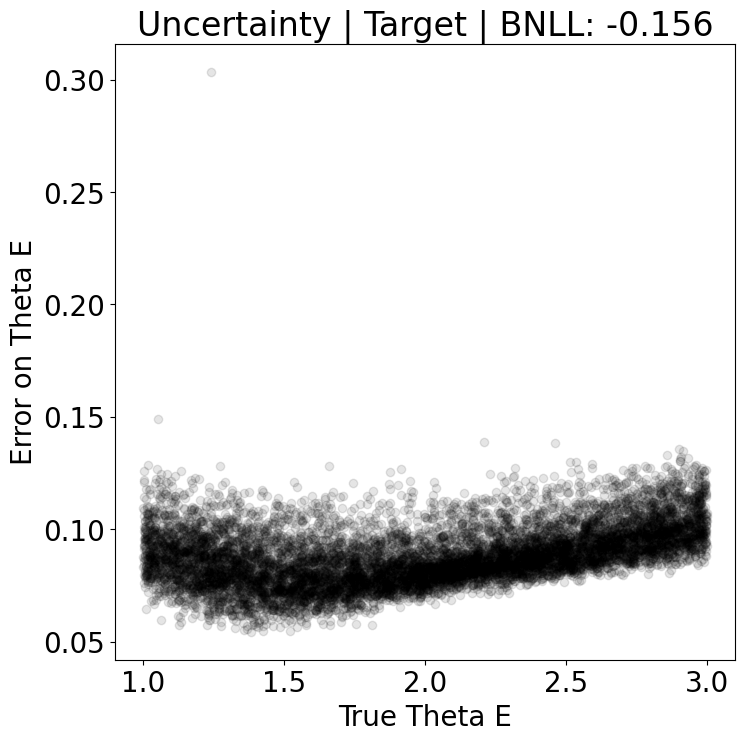

In [32]:
plt.figure(figsize=(8,8))
plt.scatter(true_target, np.sqrt(var_preds_target),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Target | BNLL: {0:.3f}'.format(np.mean(lbnll_target)))

In [33]:
def sample_variance(obs, true):
    return np.std(obs - true) ** 2

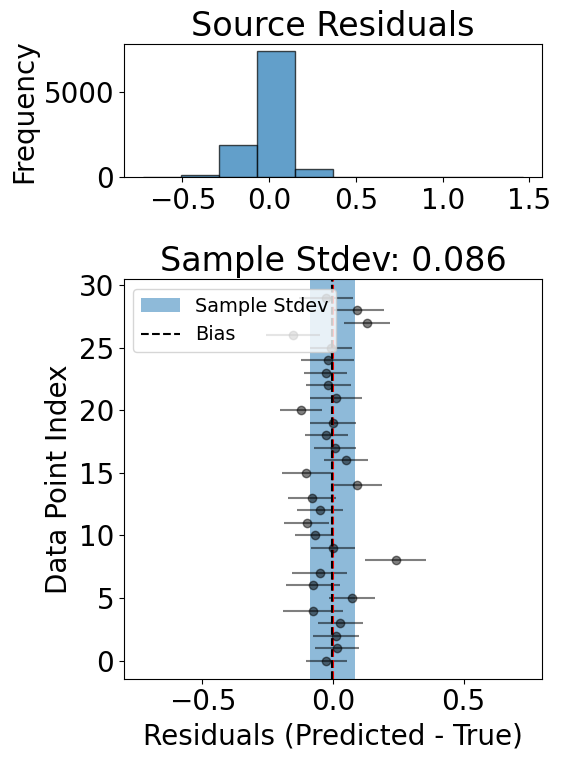

In [34]:
n_points = 30
rand_idx = np.random.choice(np.arange(len(preds_source)), n_points)
residuals = preds_source[rand_idx] - true_source[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_source[rand_idx])
sv = np.sqrt(sample_variance(preds_source, true_source))
mn = np.mean(resid_all)

# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=10, edgecolor='black', alpha=0.7)
ax_hist.set_title('Source Residuals')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=np.arange(n_points), xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel('Residuals (Predicted - True)')
ax_resid.set_ylabel('Data Point Index')
ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 'x-small')

plt.xlim(-0.8, 0.8)

plt.tight_layout()
plt.show()

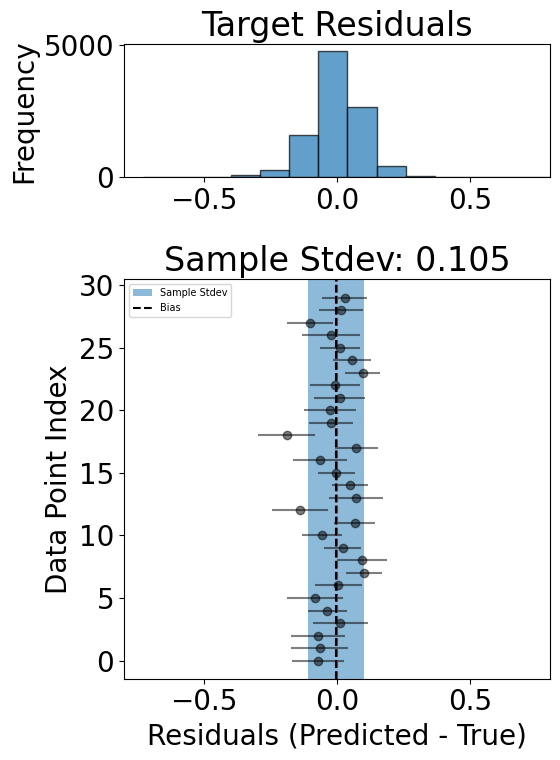

In [38]:
n_points = 30
rand_idx = np.random.choice(np.arange(len(preds_source)), n_points)
residuals = preds_target[rand_idx] - true_target[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_target[rand_idx])
sv = np.sqrt(sample_variance(preds_target, true_target))
mn = np.mean(resid_all)
# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=20, edgecolor='black', alpha=0.7)
ax_hist.set_title('Target Residuals')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=np.arange(n_points), xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel('Residuals (Predicted - True)')
ax_resid.set_ylabel('Data Point Index')
ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 7)
ax_resid.sharex(ax_hist)

plt.xlim(-0.8, 0.8)

plt.tight_layout()
plt.show()